# Time Series Modeling

In this notebook we will attempt to build a time series model to estimate the number of hourly comments left on the New York Times website. 

In [457]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

In the cell below, we import the New York Times dataset.

In [159]:
comments = pd.read_csv('comments.csv')

This dataset contains the time for every comment posted to a New York Times article from March 3, 2018 - April 1, 2018. Let's see if we can develop a model to estimate the number of comments that will be posted each hour. 

First, let's add a column to the dataframe called `comments` that has a 1 in every single row. We will use this to count the number comments that appear in an hour.

In [161]:
comments['comments'] = 1

Now convert the `createDate` column to datetime.

In [165]:
# Your code here

In [168]:
#__SOLUTION__
comments['createDate'] = pd.to_datetime(comments['createDate'])

Next set the `createDate` column as the index for the dataframe.

In [ ]:
# Your code here

In [169]:
#__SOLUTION__
comments = comments.set_index('createDate')

Now let's downsample our data so we have the total number of comments created at an hourly frequency. You will likely need to reference pandas documentation for this!

In the cell below downsample the data to an hourly frequency. Find the total number of comments created within each hour.

In [162]:
# Your code here

In [171]:
#__SOLUTION__
comments = comments.resample('H').sum()

In [173]:
comments.head(2)

,comments
createDate,
2018-02-28 19:00:00,2
2018-02-28 20:00:00,11


Great. Let's plot our timeseries below.

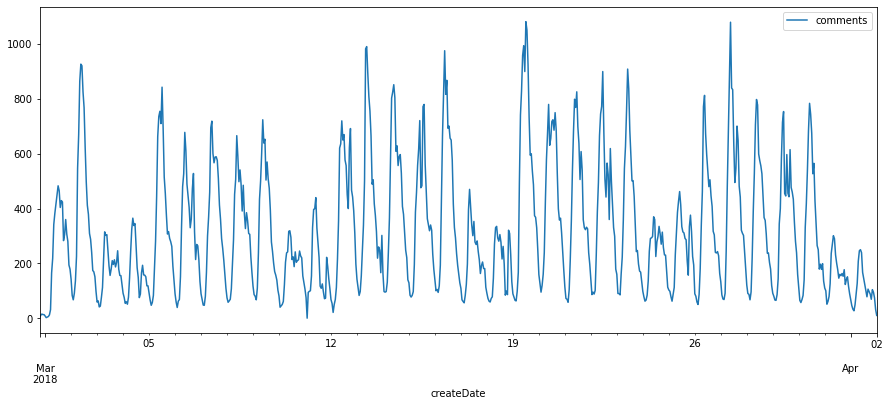

In [176]:
comments.plot(figsize=(15,6));

What can we say about this time series?

YOUR CODE HERE

Let's see if a simple differencing of the data will make it stationary. 

In the cell below, create a 1 differenced version of our timeseries and visualize the differenced time series.

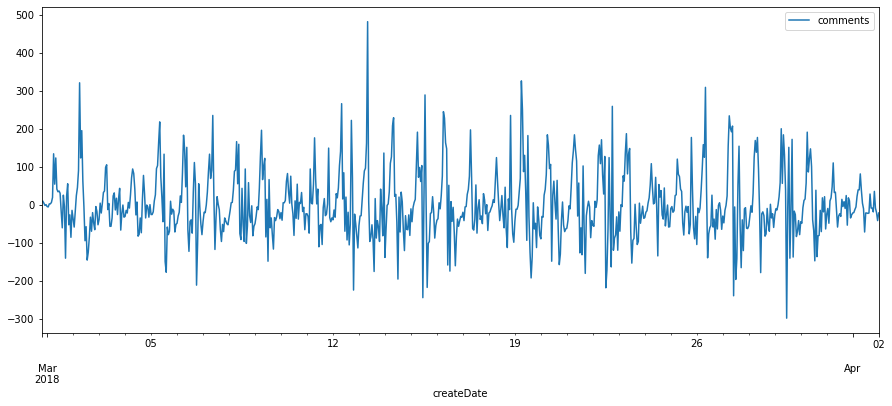

In [180]:
comments.diff().plot(figsize=(15,6));

That looks pretty good! 

In the cell below, create two variables
1. `undifferenced` set the comments column in our dataframe
2. `differenced` set the differenced version of the comments column in our dataframe

Both variables should be pandas Series objects.

In [193]:
undifferenced = comments.comments
differenced = comments.comments.diff(1).dropna()

Let's pass the differenced time series into a Dickey Fuller Test to get some empirical interpretations of our differenced time series.

We have defined a function below for running a Dickey Fuller Test. 

In [186]:
from statsmodels.tsa.stattools import adfuller

def dfuller(timeseries):
    """
    Parameters:
        
        timeseries - An array of data for a single time series.
    
    Returns:
        
        A pandas series of test statistics for a Dickey Fuller Test
    """
    
    dftest = adfuller(timeseries)

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    return dfoutput

In the cell below, pass the differenced timeseries into the `dfuller` function and interpret the results.

In [188]:
# Your code here

In [194]:
#__SOLUTION__
dfuller(differenced)

Test Statistic                -1.541504e+01
p-value                        3.087315e-28
#Lags Used                     2.000000e+01
Number of Observations Used    7.520000e+02
dtype: float64

INTERPRETATION HERE

## Modeling

### Random Walk

A random walk is a model where our prediction for each observation is just an observation we've already seen at a previous time step. In most cases, a true random walk model is using the most recent observation as the prediction for the next timestep. It is a highly naive and simple time series model, but depending on the problem and how easily "model-able" a time series is, a random walk can be quite useful.

We can visualize a random walk by shifting the data back by `i` number of rows using the `.shift` method.

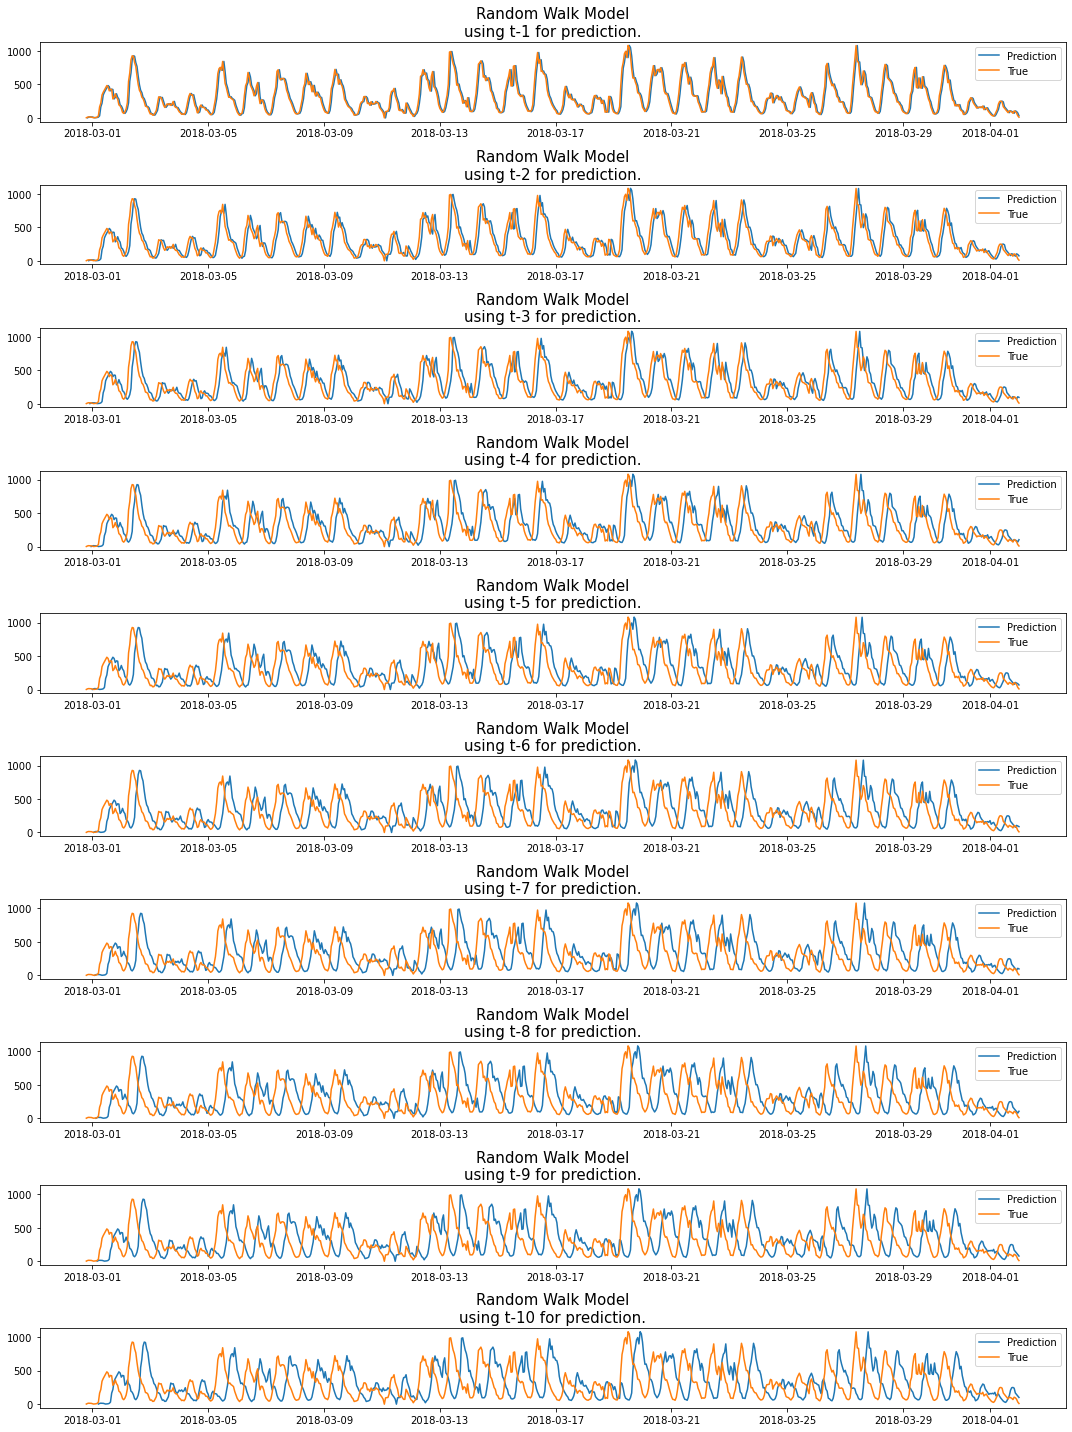

In [282]:
fig, ax = plt.subplots(10,1, figsize=(15,20))

for i in range(1,11):
    # Shift the data back to generate predictions
    shifted_series_undifferenced = undifferenced.shift(i)

    ax[i-1].plot(shifted_series_undifferenced, label='Prediction')
    ax[i-1].plot(undifferenced, label='True')
    ax[i-1].set_title(f'Random Walk Model\nusing t-{i} for prediction.',
                     fontsize=15)
    ax[i-1].legend()
fig.tight_layout()

Above we can see that using `t-1` to predict `t` produced pretty accurate results! The downside is that with a `t-1` random walk, we are only ever able predict the next time step, which means we aren't really able to predict very far into the furture.

Once we begin using timesteps around `t-4` or `t-5` for prediction prediction accuracy is really beginning to fall, and by the time we're using `t-10` we're essentially predicting the exact opposite of the true value.

## Using Statsmodels

In the cell below import the `ARIMA` model from statsmodels

In [ ]:
# Your code here

In [210]:
#__SOLUTION__
from statsmodels.tsa.arima_model import ARIMA

Next we will use sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create a train test split for our data. 

>TimeSeriesSplit is a little different than our normal train test split. It works a lot like the `KFolds` sklearn tool that we have used to create train test splits manually. Instead of returning the splits of data, TimeSeriesSplit returns the index for both the train and test splits. 

>The main thing TimeSeriesSplit does: it splits the data sequentially. The standard train_test_split function returns a random sample for both train and test which means the rows are no longer *ordered*. With time series data, we usually want to split our data sequentially so we train on early timesteps and predict on later timesteps. 

In [279]:
def train_test_split(timeseries, n_splits=2):
    
    # Create a splitter using TimeSeriesSplit
    splitter = TimeSeriesSplit(n_splits=n_splits)

    # Create a container for 
    splits = []

    # Loop over the indices for each split
    for train_idx, test_idx in splitter.split(timeseries):
        # Isolate the observations for training data
        train = timeseries.iloc[train_idx].astype(float)
        # Isolate the observations for testing data
        test = timeseries.iloc[test_idx].astype(float)
        # Append the splits to our splits container
        splits.append((train, test))

    # In this case, we only made a single split
    # So we can just pull the training and testing
    # sets out of the container
    # With full blown time series modeling
    # You might use 5 splits instead of just two!
    if n_splits==2:
        return splits[0]
    else:
        return splits

Now we can create a train test split for our **undifferenced** data.

In [285]:
train, test = train_test_split(undifferenced)

-----

A small **warning**

There is a known bug in statsmodels ([documented here](https://github.com/statsmodels/statsmodels/issues/3504)) where statmodels will return the following error message:

```
UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'
```

The solution for this problem is to convert your training dataset to a `float` datatype

I have added that logic to the function above, but #TheMoreYouKnow


----

### Differencing with ARIMA

In previous notebooks, we have indicating that most Time Series models expect to be fed **stationary** data.  In this case we were able to make our series stationary by *differencing* our data.

Let's repeat that process here. 

In order to make our lives easier, we will use statsmodels to difference our data via the **A.R.I.M.A.** class. 

We will break down what ARIMA is shortly, but for now, we will focus on the `I` term in ARIMA, which stands for **integrated**. A time series which has been be differenced to become stationary is said to have been integrated [[1]](https://people.duke.edu/~rnau/411arim.htm). 

ARIMA models have a required hyperparameter called `order`, that is a tuple containing 3 integers. The integers are reffered to as `(p, d, q)`

Statsmodels documentation on what each of these integers represent is total trash so let's dig into them...

We will start with the *second* integer: `d` 

`d` represents our order of differencing, so putting a one there in our model will apply a first order difference.

In the cell below define a variable called `random_walk_order` that is set to a tuple of three integers.

* The value at the first index of the tuple should be `0`.
* The value at the second index of the tuple should `1`.
* The value at the third index of the tuple should be `0`.

In [342]:
# Your code here

In [343]:
random_walk_order = (0,1,0)

Now to create an ARIMA model, you initialize an instance of the `ARIMA` class, and pass in your training data and set order to the tuple of integers: `order=random_walk_order`.

In the cell below, create a model called `random_walk`

In [344]:
# Your code here

In [349]:
random_walk = ARIMA(train, order=random_walk_order)

Now, because we are using statsmodels, we can fit the model by simply calling the method `.fit`.

In [350]:
random_walk = random_walk.fit()

Now we can take a look at how our model did on the training data!

In the cell below, we create predictions for our random walk model by calling the `.predict` method. 

For ARIMA models, we can generate predictions for our entire training set by calling predict

In [351]:
train_preds = random_walk.predict()

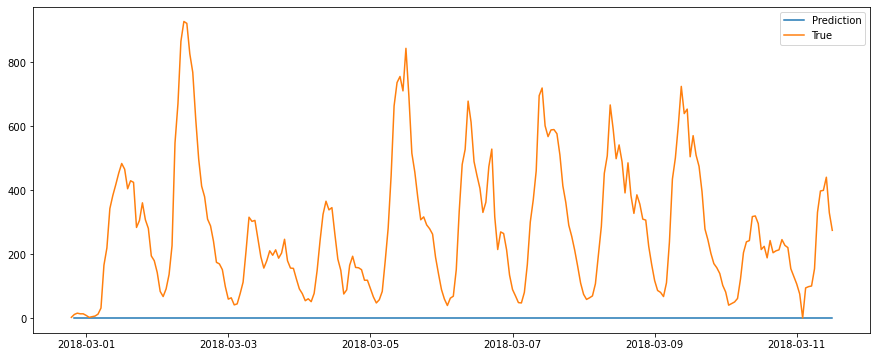

In [352]:
plt.figure(figsize=(15,6))
plt.plot(train_preds, label='Prediction')
plt.plot(train, label='True')
plt.legend();

This looks really bad! The reason why our predictions look so crummy is that they are the *differenced* predictions for our timeseries. 

What we usually want is to convert the differenced predictions back to the original scale of the time series. To do this, we have to set the argument to `typ` to `'levels'`. 

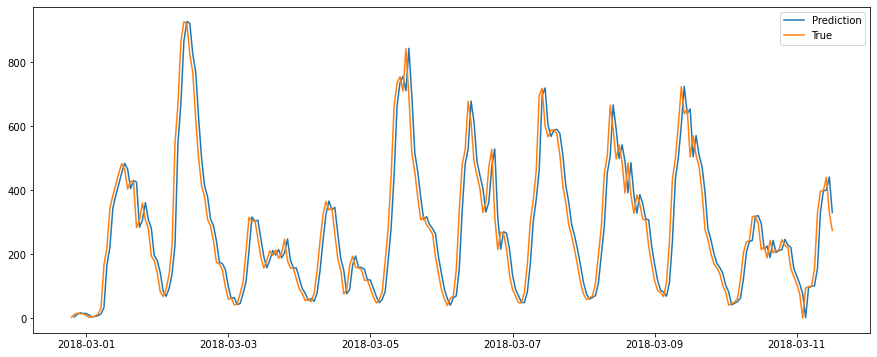

In [353]:
train_preds = random_walk.predict(typ='levels')

plt.figure(figsize=(15,6))
plt.plot(train_preds, label='Prediction')
plt.plot(train, label='True')
plt.legend();

That looks much better! To get predictions for our testing data we can pass in the starting time step and the end timestep we'd like to make predictions for.

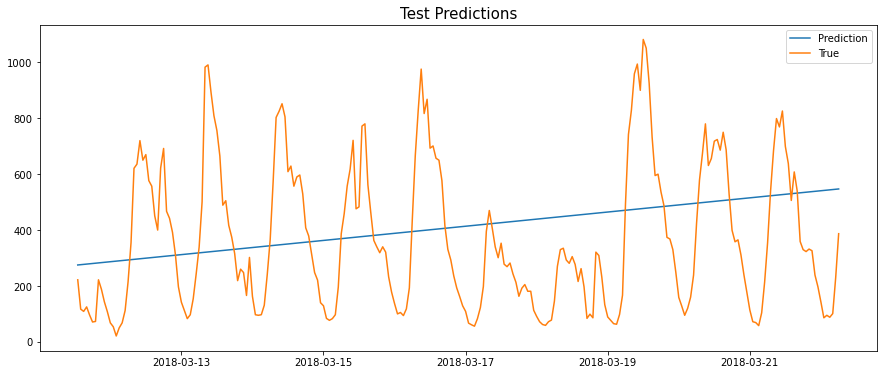

In [354]:
test_preds = random_walk.predict(test.index[0], test.index[-1], typ='levels')

plt.figure(figsize=(15,6))
plt.plot(test_preds, label='Prediction')
plt.plot(test, label='True')
plt.title('Test Predictions', fontsize=15)
plt.legend();

Let's calculate the RMSE for our train and test predictions

In the cell below, calculate the mean squared error for the training and testing predictions:

In [ ]:
# Your code here

In [330]:
#__SOLUTION__
from sklearn.metrics import mean_squared_error

# Because the model has a difference of 1, we have to remove the first
# observation in the true training values
train_error = mean_squared_error(train[1:], train_preds, squared=False)
test_error = mean_squared_error(test, test_preds, squared=False)

print('Train error:', train_error)
print('Test error: ', test_error)


Train error: 73.3009925167732
Test error:  269.9386297689067


As the visualization and the metrics show, we are very overfit to our training data. 

By removing the trend from our data through differencing, we assume that our data passes a significance test that the mean and variance are constant throughout. But it is not just white noise. If it were, our models could do no better than random predictions around the mean.

Our task now is to find more patterns in the series.


## The Autoregressive Model (AR)
Our next attempt at a model is the autoregressive model, which is a timeseries regressed on its previous values

This brings us to the first integer in the `order` tuple. `p`

`p` indicated the number of **lags** used for a model. If we set `p` to `1` then we set the `y-1` timestep as a new column in our dataframe and we run a regression model using the `y-1` timestep as an independent variable. The equation for our model would look like this:

$y_{t} = \phi_{0} + \phi_{1}y_{t-1} + \varepsilon_{t}$


The above formula is a first order autoregressive model (AR1), which finds the best fit weight $\phi$ which, multiplied by the point previous to a point in question, yields the best fit model.

So if we wanted to do this manually, it would look something like this:

In [359]:
ar_dataframe = pd.DataFrame().assign(lag_1 = train.shift(1),
                                    comments=train).dropna()
ar_dataframe.head()

,lag_1,comments
createDate,,
2018-02-28 20:00:00,2.0,11.0
2018-02-28 21:00:00,11.0,15.0
2018-02-28 22:00:00,15.0,13.0
2018-02-28 23:00:00,13.0,13.0
2018-03-01 00:00:00,13.0,8.0


We would then fit a linear regression model to this data.

In [375]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(ar_dataframe[['lag_1']], ar_dataframe.comments)

print('Sklearn coefficient:', lr.coef_[0])

Sklearn coefficient: 0.9320424347249218


In [376]:
model = ARIMA(train, order=(1,0,0))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               comments   No. Observations:                  258
Model:                     ARMA(1, 0)   Log Likelihood               -1470.851
Method:                       css-mle   S.D. of innovations             72.097
Date:                Fri, 30 Jul 2021   AIC                           2947.701
Time:                        12:49:12   BIC                           2958.360
Sample:                    02-28-2018   HQIC                          2951.987
                         - 03-11-2018                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            264.0966     65.740      4.017      0.000     135.248     392.945
ar.L1.comments     0.9351      0.021     43.537      0.000       0.893       0.977
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0694           +0.0000j            1.0694            0.0000
-----------------------------------------------------------------------------
"""

If we look at the summary output for our `ar_model`, the coefficent is very similar to sklearn's. 

In the cell below, create a variable called `ar_model_order` that is a tuple containing three integers. This order should tell the model to create an ARIMA model that differences the data by 1 and to use a lag of 1.

In [377]:
# Your code here

In [378]:
#__SOLUTION__
ar_model_order = (1,1,0)

In the cell below:

1. Initialize a model called `ar_model` that receives the training data and the order tuple.
2. Fit the model

In [381]:
ar_model = ARIMA(train, order=ar_model_order)
ar_model = ar_model.fit()

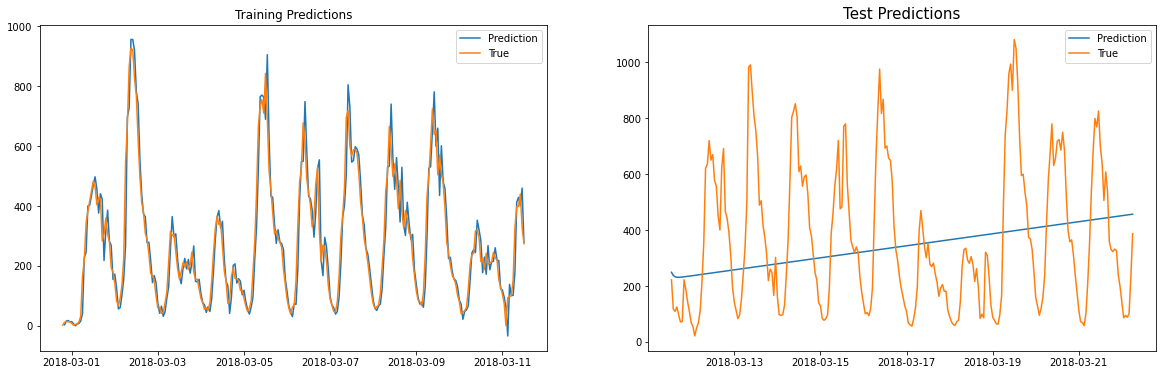

In [398]:
def plot_results(model, train, test):

    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_preds = model.predict(typ='levels')

    ax[0].plot(train_preds, label='Prediction')
    ax[0].plot(train, label='True')
    ax[0].set_title('Training Predictions')
    ax[0].legend()

    test_preds = ar_model.predict(test.index[0], test.index[-1], typ='levels')

    ax[1].plot(test_preds, label='Prediction')
    ax[1].plot(test, label='True')
    ax[1].set_title('Test Predictions', fontsize=15)
    ax[1].legend();
    
plot_results(ar_model, train, test)

In [403]:
train_error = mean_squared_error(train[1:], train_preds, squared=False)
test_error = mean_squared_error(test, test_preds, squared=False)

print('Train error:', train_error)
print('Test error: ', test_error)

Train error: 64.8337986303274
Test error:  264.8525333949882


We didn't improve by much, but we do see an improvement in our model's performance for both train and testing data. 

An additional metric that is useful to check with ARIMA models is `aic`. A lower `aic` value usually means a better model!

In [395]:
print('Random Walk:', random_walk.aic)
print('    (1,1,0):', ar_model.aic)

Random Walk: 2940.7455187947216
    (1,1,0): 2879.894131115083


## Moving Average Model (MA)

The next type of model is based on error. The idea behind the moving average model is to make a prediciton based on how far off we were the day before.

$$\large Y_t = \mu +\epsilon_t + \theta * \epsilon_{t-1}$$

The moving average model is a pretty cool idea. We make a prediction, see how far off we were, then adjust our next prediction by a factor of how far off our pervious prediction was.

In our ARIMA model, the q term of our order (p,d,q) refers to the MA component. To use one lagged error, we put 1 in the q position.



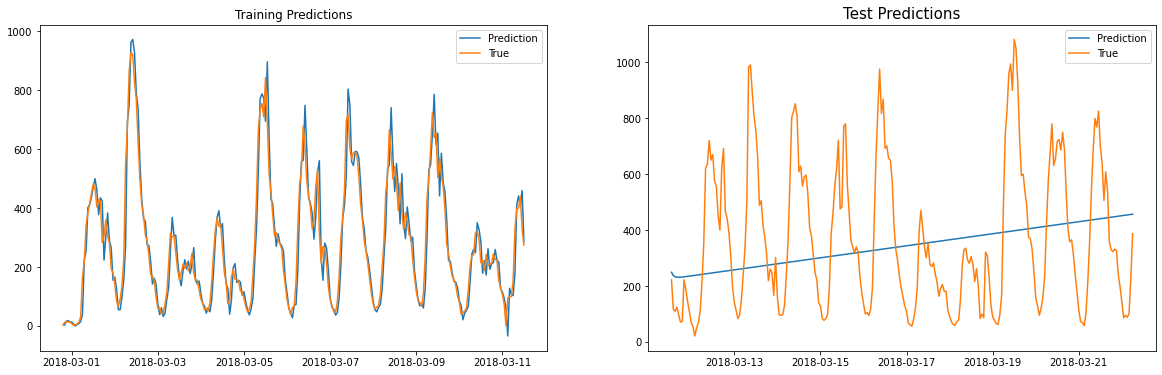

In [410]:
ma_1 = ARIMA(train, (1,1,1)).fit()

plot_results(ma_1, train, test)

In [411]:
def print_scores(model, train, test):
    train_preds = model.predict(typ='levels')
    test_preds = ar_model.predict(test.index[0], test.index[-1], typ='levels')
    train_error = mean_squared_error(train[1:], train_preds, squared=False)
    test_error = mean_squared_error(test, test_preds, squared=False)
    print('AIC:', model.aic)

    print('Train error:', train_error)
    print('Test error: ', test_error)
    
print_scores(ma_1, train, test)

AIC: 2879.4155342727654
Train error: 64.51965524390509
Test error:  264.8525333949882


### How do we select p, d, q?

The short answer is most people loop over a bunch of options and find the combination that produced the best scores.

But a useful tool for identifying decent settings is by using autocorrelation and partial autocorrelation. 

In [412]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

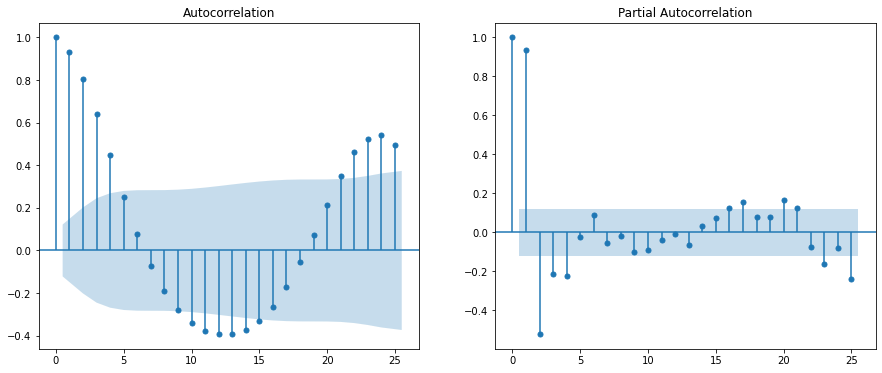

In [416]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

plot_acf(train, ax[0])
plot_pacf(train, ax[1])
plt.show()

How do we interpret this plot?

AIC: 2875.2216773072923
Train error: 63.48094715594166
Test error:  264.8525333949882


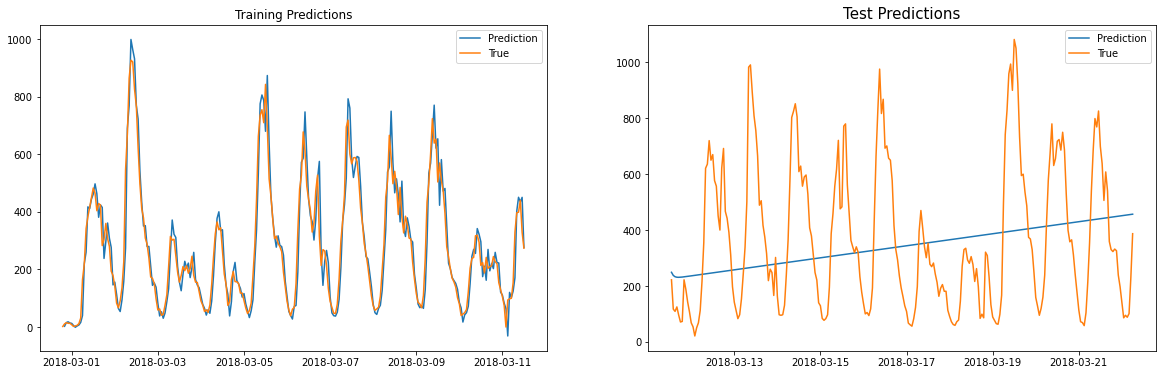

In [419]:
ma_1 = ARIMA(train, (1,1,3)).fit()

plot_results(ma_1, train, test)
print_scores(ma_1, train, test)